In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.utils.data as Data
import numpy as np
import matplotlib.pyplot as plt
import h5py
from Models import *
from torch.utils.data import Dataset, DataLoader, TensorDataset
from utils import *

In [ ]:
matread = MatRead('Problem_1_student/Data/Material_C.mat')
strain = matread.get_strain()
stress = matread.get_stress()
strain = strain.transpose(1,2)
stress = stress.transpose(1,2)
strain = strain / (strain.std(axis=(0,2)) + 1e-8).reshape(-1,1)
stress = stress / (stress.std(axis=(0,2)) + 1e-8).reshape(-1,1)
net = UNet_DenseBottleneck(6, 64)
loss_fn = nn.MSELoss()
optimiser = torch.optim.Adam(net.parameters(), lr=2e-4)

In [55]:
# partition the data
strain_train = strain[:770]
strain_test = strain[770:]
stress_train = stress[:770]
stress_test = stress[770:]

In [56]:
batch_size = 64
train_loader = DataLoader(TensorDataset(strain_train, stress_train), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(strain_test, stress_test), batch_size=batch_size, shuffle=False)

In [57]:
from tqdm import tqdm
losses = []
test_losses = []

In [58]:
for epoch in range(1000):

    net.train()
    running_loss = 0.0

    for batch_idx, (strain_batch, stress_batch) in enumerate(train_loader):
        optimiser.zero_grad()
        y = net.forward(strain_batch)
        loss = loss_fn(y, stress_batch)
        loss.backward()
        optimiser.step()
        running_loss += loss.item()
    avg_loss = running_loss / len(train_loader)
    losses.append(avg_loss)

    with torch.no_grad():  # Disable gradient calculation for validation
        running_val_loss = 0.0
        for strain_batch, stress_batch in val_loader:
            output = net(strain_batch)  # Forward pass
            val_loss = loss_fn(output, stress_batch)
            running_val_loss += val_loss.item()

        avg_val_loss = running_val_loss / len(val_loader)
        test_losses.append(avg_val_loss)
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Training loss: {avg_loss}, Validation loss: {avg_val_loss}")


Epoch 0, Training loss: 0.940299433011275, Validation loss: 1.0007969240347545
Epoch 10, Training loss: 0.34855867807681745, Validation loss: 0.3418545573949814
Epoch 20, Training loss: 0.2766950405561007, Validation loss: 0.26846448332071304
Epoch 30, Training loss: 0.22495573873703295, Validation loss: 0.22235832115014395
Epoch 40, Training loss: 0.19669496669219091, Validation loss: 0.18828594436248144
Epoch 50, Training loss: 0.1632575702208739, Validation loss: 0.16264480352401733
Epoch 60, Training loss: 0.1653518951856173, Validation loss: 0.1507084717353185
Epoch 70, Training loss: 0.1479164958000183, Validation loss: 0.14259393016497293
Epoch 80, Training loss: 0.13343170485817468, Validation loss: 0.13358434538046518
Epoch 90, Training loss: 0.13087701797485352, Validation loss: 0.1254086196422577
Epoch 100, Training loss: 0.11916261109021994, Validation loss: 0.11841049169500668
Epoch 110, Training loss: 0.11685727995175582, Validation loss: 0.11413208519419034
Epoch 120, Tr

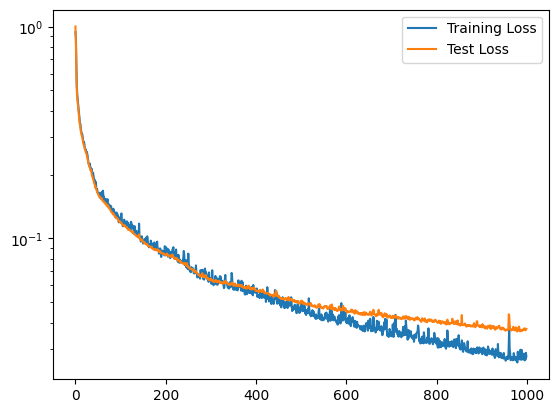

In [59]:
plt.plot(losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.yscale('log')
plt.legend()

In [ ]:
x_test = strain_test[20].unsqueeze(0)
y_true = stress_test[20].unsqueeze(0)
y_pred = net.forward(x_test)
# plt.plot(x_test[0,0].squeeze(0).detach().numpy(), label='strain')
plt.plot(x_test[0,0].detach().numpy(), y_true[0,0].squeeze(0).detach().numpy(), label='true stress')
plt.plot(x_test[0,0].detach().numpy(), y_pred[0,0].squeeze(0).detach().numpy(), label='predicted stress')
plt.legend()
y_pred.squeeze(0).shape

In [ ]:
y_pred.shape

torch.Size([1, 50, 1])

In [ ]:
data_files = ['Problem_1_student/Data/Material_A.mat', 'Problem_1_student/Data/Material_B.mat', 'Problem_1_student/Data/Material_C.mat']
materials = ['A', 'B', 'C']
hidden_dims = [0, 16, 64]

In [71]:
models = {} # [material, hidden_dim]: model
test_losses = {} # [material, hidden_dim]: [test_losses]
train_losses = {} # [material, hidden_dim]: [train_losses]
for material in materials:
    for dim in hidden_dims:
        losses[material, dim] = []
        if material != 'C':
            models[material, dim] = UNet_DenseBottleneck(6, dim)
        else:
            models[material, dim] = UNet_DenseBottleneck(1, dim)

        test_losses[material, dim] = []
        train_losses[material, dim] = []

c:\Users\kiril\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\init.py:452: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


In [72]:
for material, dim in losses.keys():
    print(material, dim, count_trainable_parameters(models[material, dim]))

A 0 17860
A 16 30164
A 64 67076
B 0 17860
B 16 30164
B 64 67076
C 0 17190
C 16 29494
C 64 66406


In [73]:
for material in materials:
    matread = MatRead(f'Problem_1_student/Data/Material_{material}.mat')
    strain = matread.get_strain()
    stress = matread.get_stress()
    strain = strain.transpose(1,2)
    stress = stress.transpose(1,2)
    #normalise the data
    strain = strain / (strain.std(axis=(0,2)) + 1e-8).reshape(-1,1)
    stress = stress / (stress.std(axis=(0,2)) + 1e-8).reshape(-1,1)

    # partition the data
    strain_train = strain[:770]
    strain_test = strain[770:]
    stress_train = stress[:770]
    stress_test = stress[770:]

    #create data loaders
    test_loader = DataLoader(TensorDataset(strain_test, stress_test), batch_size=batch_size, shuffle=False)
    train_loader = DataLoader(TensorDataset(strain_train, stress_train), batch_size=batch_size, shuffle=True)

    for dim in hidden_dims:
        net = models[material, dim]
        loss_fn = nn.MSELoss()
        optimiser = torch.optim.Adam(net.parameters(), lr=2e-4)
        batch_size = 64
        train_loader = DataLoader(TensorDataset(strain_train, stress_train), batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(TensorDataset(strain_test, stress_test), batch_size=batch_size, shuffle=False)
        train_loss = []
        test_loss = []

        for epoch in range(11):
            net.train()
            running_loss = 0.0

            for batch_idx, (strain_batch, stress_batch) in enumerate(train_loader):
                optimiser.zero_grad()
                y = net.forward(strain_batch)
                loss = loss_fn(y, stress_batch)
                loss.backward()
                optimiser.step()
                running_loss += loss.item()
            avg_loss = running_loss / len(train_loader)
            train_loss.append(avg_loss)

            with torch.no_grad():  # Disable gradient calculation for validation
                running_val_loss = 0.0
                for strain_batch, stress_batch in val_loader:
                    output = net(strain_batch)  # Forward pass
                    val_loss = loss_fn(output, stress_batch)
                    running_val_loss += val_loss.item()

                avg_val_loss = running_val_loss / len(val_loader)
                test_loss.append(avg_val_loss)
            
            if epoch % 10 == 0:
                print(f"Materail: {material}, 'Bottleneck Dims: {dim}, Epoch: {epoch}, Training loss: {avg_loss}, Validation loss: {avg_val_loss}")


        train_losses[material, dim] = train_loss
        test_losses[material, dim] = test_loss


c:\Users\kiril\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\conv.py:306: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ..\aten\src\ATen\native\Convolution.cpp:1032.)
  return F.conv1d(input, weight, bias, self.stride,


Materail: A, 'Bottleneck Dims: 0, Epoch: 0, Training loss: 0.6689422061810126, Validation loss: 0.7338605026404063
Materail: A, 'Bottleneck Dims: 0, Epoch: 10, Training loss: 0.6120539834866157, Validation loss: 0.6163104474544525
Materail: A, 'Bottleneck Dims: 16, Epoch: 0, Training loss: 0.7599356403717628, Validation loss: 0.7450224558512369
Materail: A, 'Bottleneck Dims: 16, Epoch: 10, Training loss: 0.5051089318899008, Validation loss: 0.4825282295544942
Materail: A, 'Bottleneck Dims: 64, Epoch: 0, Training loss: 0.6456021758226248, Validation loss: 0.6522136628627777
Materail: A, 'Bottleneck Dims: 64, Epoch: 10, Training loss: 0.4362626878114847, Validation loss: 0.42737094064553577
Materail: B, 'Bottleneck Dims: 0, Epoch: 0, Training loss: 1.0601219122226422, Validation loss: 1.0193231801191966
Materail: B, 'Bottleneck Dims: 0, Epoch: 10, Training loss: 0.8460951997683599, Validation loss: 0.814567377169927
Materail: B, 'Bottleneck Dims: 16, Epoch: 0, Training loss: 1.0340278423